In [34]:
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/heteronyms-052722 -O heteronyms
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/cmudict-0.7b_nv22.08 -O cmudict-0.7b

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [1]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio

In [ ]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp32')

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [24]:
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

In [25]:
fastpitch, generator_train_setup = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_fastpitch')


Using cache found in C:\Users\maxro/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\maxro/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch/SpeechSynthesis/HiFiGAN\common\utils.py:217: SyntaxWarning: invalid escape sequence '\d'
  find = lambda name: {int(re.search('_(\d+).pt', fn).group(1)): fn
c:\Users\maxro\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:1918: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2002.)
  return torch._lu_with_info(A, pivot=pivot, check_errors=(not get_infos))


In [35]:
tp = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_textprocessing_utils', cmudict_path="cmudict-0.7b", heteronyms_path="heteronyms")


Using cache found in C:\Users\maxro/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


In [42]:
fastpitch = fastpitch.to(device)
waveglow = waveglow.to(device)

In [217]:
text = "Death comes to all, but great achievements raise a monument which shall endure until the sun grows old."

In [218]:
# batches = tp.prepare_input_sequence(text.split('.')[:-1], batch_size=1)
batches = tp.prepare_input_sequence([text], batch_size=1)

{D EH1 TH} {K AH1 M Z} to {AO1 L}, {B AH1 T} {G R EY1 T} {AH0 CH IY1 V M AH0 N T S} {R EY1 Z} a monument which {SH AE1 L} endure {AH0 N T IH1 L} the {S AH1 N} {G R OW1 Z} {OW1 L D}.


In [219]:
batches

[{'text': tensor([[ 90,  94, 134,  11, 116,  74, 118, 146,  11,  57,  52,  11,  78, 117,
             6,  11,  88,  74, 133,  11, 105, 130, 102, 133,  11,  73,  89, 113,
           143, 118,  73, 119, 133, 131,  11, 130, 102, 146,  11,  38,  11,  50,
            52,  51,  58,  50,  42,  51,  57,  11,  60,  45,  46,  40,  45,  11,
           132,  70, 117,  11,  42,  51,  41,  58,  55,  42,  11,  73, 119, 133,
           109, 117,  11,  57,  45,  42,  11, 131,  74, 119,  11, 105, 130, 123,
           146,  11, 123, 117,  90,   7]]),
  'text_lens': tensor([90])}]

In [220]:
gen_kw = {
    'pace': 1.1,
    'speaker': 0,
    'pitch_tgt': None,
    'pitch_transform': None
}

In [221]:
for batch in batches:
    with torch.no_grad():
        print(batch['text'].shape)
        mel, mel_lens, *_ = fastpitch(batch['text'].to(device), **gen_kw)
        print(mel.shape, batch['text'].shape)
        audios = waveglow.infer(mel.to(device)).float()
        audios = audios.squeeze(1)
        # audios = hifigan(mel).float()
        # audios = denoiser(audios.squeeze(1), denoising_strength)
        # audios = audios.squeeze(1) * vocoder_train_setup['max_wav_value']

torch.Size([1, 90])
torch.Size([1, 80, 531]) torch.Size([1, 90])


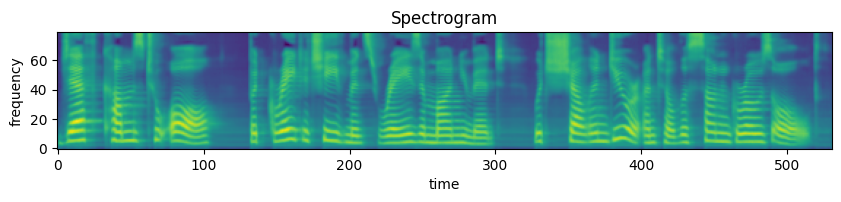

In [222]:
plt.figure(figsize=(10,12))
res_mel = mel[0].detach().cpu().numpy()
plt.imshow(res_mel, origin='lower')
plt.xlabel('time')
plt.ylabel('frequency')
_=plt.title('Spectrogram')

In [223]:
audio_numpy = audios[0].cpu().numpy()
Audio(audio_numpy, rate=22050)
# audio_numpy = audios[1].cpu().numpy()
# Audio(audio_numpy, rate=22050)
# audio_numpy = audios[2].cpu().numpy()
# Audio(audio_numpy, rate=22050)